## Displacement

In [20]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.Displacement.extraction import AE, DamageAE, TripletAE
from dataset.Displacement.FeatureExtraction import FeatureExtractionDataset
from torch.utils.data import DataLoader

In [21]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Displacement/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [22]:
ae = AE.load_from_checkpoint("./Logs/Extraction/Displacement-AE/unet/version_0/checkpoints/epoch=00499-val_loss=0.00009306.ckpt").eval().to("cuda")
dae = DamageAE.load_from_checkpoint("./Logs/Extraction/Displacement-DamageAE/unet-regression/version_0/checkpoints/epoch=00118-val_loss=0.02089089.ckpt").eval().to("cuda")
tae = TripletAE.load_from_checkpoint("./Logs/Extraction/Displacement-TripletAE/unet/version_0/checkpoints/epoch=00466-val_loss=0.00045464.ckpt").eval().to("cuda")

In [23]:
mode = "test"
dataset = FeatureExtractionDataset(path="./Data", mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [24]:
ae_representation = []
dae_representation = []
tae_representation = []
class_list = []

for signal, label, situation in dataloader:
    with torch.no_grad():
        if mode == "train":
            signal = signal[0]
        signal = signal.to("cuda")       
        ae_representation += torch.permute(ae.encoder(signal)[-1], (0, 2, 1))
        dae_representation += torch.permute(dae.encoder(signal)[-1], (0, 2, 1))
        tae_representation += torch.permute(tae.encoder(signal)[-1], (0, 2, 1))
        class_list += [situation]

class_list = torch.concat(class_list).cpu().numpy()
ae_representation = torch.concat(ae_representation).cpu().numpy()
dae_representation = torch.concat(dae_representation).cpu().numpy()
tae_representation = torch.concat(tae_representation).cpu().numpy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

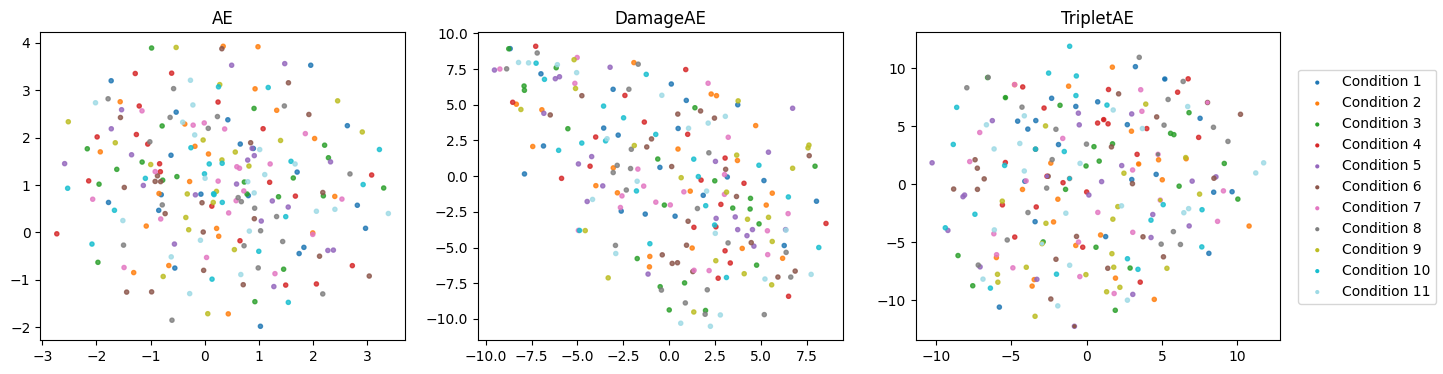

In [25]:
from sklearn.manifold import TSNE
from matplotlib.pyplot import scatter
import matplotlib.cm as cm

cmp = cm.get_cmap('tab20')


fig, ax = plt.subplots(1, 3, figsize=(16, 4))
embedded = TSNE(n_components=2, random_state=0).fit_transform(ae_representation)
ax[0].scatter(embedded[:, 0], embedded[:, 1], c=class_list, marker=".", alpha=0.8, cmap="tab20")
ax[0].set_title("AE")
embedded = TSNE(n_components=2, random_state=0).fit_transform(dae_representation)
ax[1].scatter(embedded[:, 0], embedded[:, 1], c=class_list, marker=".", alpha=0.8, cmap="tab20")
ax[1].set_title("DamageAE")
embedded = TSNE(n_components=2, random_state=0).fit_transform(tae_representation)
ax[2].scatter(embedded[:, 0], embedded[:, 1], c=class_list, marker=".", alpha=0.8, cmap="tab20")
ax[2].set_title("TripletAE")

index = embedded.shape[0] // 11 - 5
legend_elements = [scatter(embedded[i*index, 0], embedded[i*index, 1], edgecolors='none', marker='.', c=cmp((i-1)*2)) for i in range(1, 12)]
fig.legend(handles=legend_elements, labels=[f"Condition {i+1}" for i in range(11)], loc ='right', ncol=1)
plt.savefig(f"TSNE({mode}).svg", bbox_inches='tight')

In [26]:
signal = dataset[0][0].unsqueeze(0).to("cuda")

In [27]:
signal = []
AE_prediction = []
dAE_prediction = []
tAE_prediction = []

with torch.no_grad():
    for input, label, situation in dataloader: 
        input = input.to("cuda")
        signal  += input.unsqueeze(0)
        AE_prediction  += ae(input)[0].unsqueeze(0)
        dAE_prediction  += dae(input)[0].unsqueeze(0)
        tAE_prediction += tae(input)[0].unsqueeze(0)

signal = torch.concat(signal).cpu()
AE_prediction = torch.concat(AE_prediction).cpu()
dAE_prediction = torch.concat(dAE_prediction).cpu()
tAE_prediction = torch.concat(tAE_prediction).cpu()

In [28]:
signal = denormalize(signal)
AE_prediction = denormalize(AE_prediction)
dAE_prediction = denormalize(dAE_prediction)
tAE_prediction = denormalize(tAE_prediction)

In [29]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_ae = mean_squared_error(signal, AE_prediction)
mse_dae = mean_squared_error(signal, dAE_prediction)
mse_tae = mean_squared_error(signal, tAE_prediction)
print(f"MSE of AE: {mse_ae:.3E}")
print(f"MSE of DamageAE: {mse_dae:.3E}")
print(f"MSE of TripletAE: {mse_tae:.3E}")

rmse_ae = torch.sqrt(mse_ae)
rmse_dae = torch.sqrt(mse_dae)
rmse_tae = torch.sqrt(mse_tae)
print(f"RMSE of AE: {rmse_ae:.3E}")
print(f"RMSE of DamageAE: {rmse_dae:.3E}")
print(f"RMSE of TripletAE: {rmse_tae:.3E}")

nrmse_ae = rmse_ae / (signal.max() - signal.min())
nrmse_dae = rmse_dae / (signal.max() - signal.min())
nrmse_tae = rmse_tae / (signal.max() - signal.min())
print(f"NRMSE of AE: {nrmse_ae*100:.2f} %")
print(f"NRMSE of DamageAE: {nrmse_dae*100:.2f} %")
print(f"NRMSE of TripletAE: {nrmse_tae*100:.2f} %")



MSE of AE: 4.241E-05
MSE of DamageAE: 3.749E-04
MSE of TripletAE: 1.967E-04
RMSE of AE: 6.513E-03
RMSE of DamageAE: 1.936E-02
RMSE of TripletAE: 1.403E-02
NRMSE of AE: 0.85 %
NRMSE of DamageAE: 2.53 %
NRMSE of TripletAE: 1.83 %


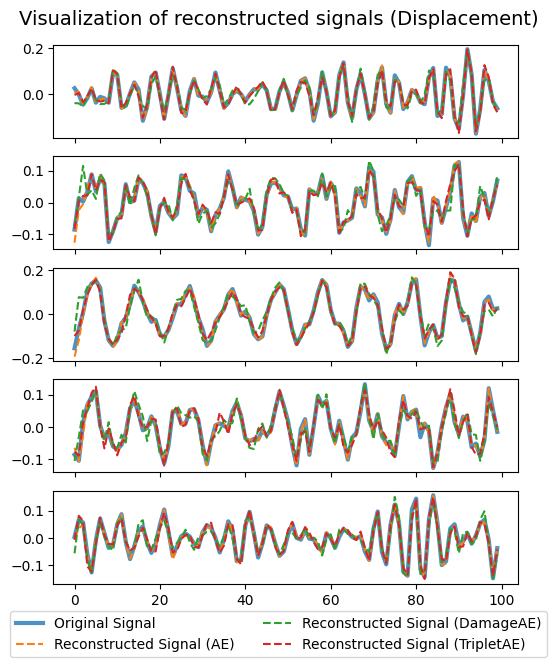

In [30]:
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
length = 100
for i in range(5):
    line1 = axes[i].plot(range(len(signal[0, i, :length])), signal[0, i, :length], color="tab:blue", linewidth=3, alpha=0.8,   label="Original Signal")
    line2 = axes[i].plot(range(len(AE_prediction[0, i, :length])), AE_prediction[0, i, :length], color="tab:orange", linestyle='dashed', label="Reconstructed Signal (AE)")
    line3 = axes[i].plot(range(len(dAE_prediction[0, i, :length])), dAE_prediction[0, i, :length], color="tab:green", linestyle='dashed', label="Reconstructed Signal (DamageAE)")
    line4 = axes[i].plot(range(len(tAE_prediction[0, i, :length])), tAE_prediction[0, i, :length], color="tab:red", linestyle='dashed', label="Reconstructed Signal (TripletAE)")
fig.legend(handles =[line1[0], line2[0], line3[0], line4[0]], loc ='lower center', ncol=2)
fig.suptitle('Visualization of reconstructed signals (Displacement)', fontsize=14, y=0.93)

plt.savefig(f"./reconstructed-disp({mode}).svg", bbox_inches='tight')

## Acceleration

In [31]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.Acceleration.extraction import AE
from dataset.Acceleration.FeatureExtraction import FeatureExtractionDataset
from torch.utils.data import DataLoader

In [32]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Acceleration/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [33]:
ae = AE.load_from_checkpoint("./Logs/Extraction/Acceleration-AE/unet/version_0/checkpoints/epoch=00498-val_loss=0.00069342.ckpt").eval().to("cuda")

In [34]:
mode = "test"
dataset = FeatureExtractionDataset(path="./Data", mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [35]:
signal = []
AE_prediction = []


with torch.no_grad():
    for input in dataloader: 
        input = input.to("cuda")
        signal  += input.unsqueeze(0)
        AE_prediction  += ae(input)[0].unsqueeze(0)


signal = torch.concat(signal).cpu()
AE_prediction = torch.concat(AE_prediction).cpu()


In [36]:
signal = denormalize(signal)
AE_prediction = denormalize(AE_prediction)

In [40]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_ae = mean_squared_error(signal, AE_prediction)
print(f"MSE of AE: {mse_ae:.3E}")

rmse_ae = torch.sqrt(mse_ae)
print(f"RMSE of AE: {rmse_ae:.3E}")

nrmse_ae= rmse_ae / (signal.max() - signal.min())
print(f"NRMSE of AE: {nrmse_ae*100:.2f} %")

MSE of AE: 1.247E-05
RMSE of AE: 3.532E-03
NRMSE of AE: 1.56 %


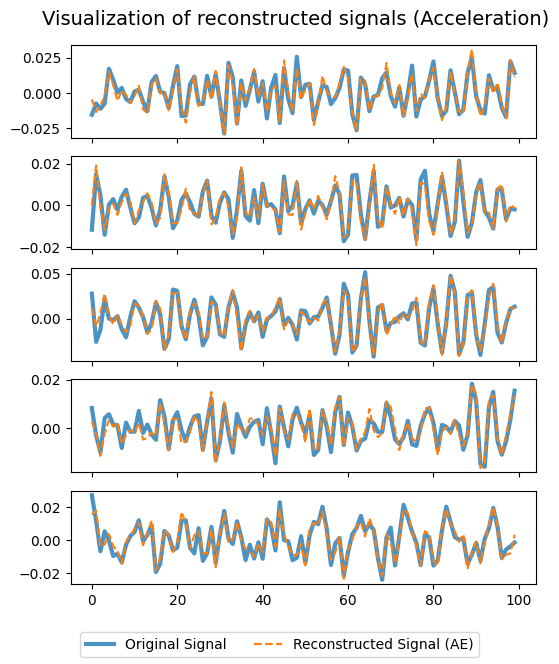

In [38]:
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
length = 100
for i in range(5):
    line1 = axes[i].plot(range(len(signal[0, i, :length])), signal[0, i, :length], color="tab:blue", linewidth=3, alpha=0.8,   label="Original Signal")
    line2 = axes[i].plot(range(len(AE_prediction[0, i, :length])), AE_prediction[0, i, :length], color="tab:orange", linestyle='dashed', label="Reconstructed Signal (AE)")
fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=4)
fig.suptitle('Visualization of reconstructed signals (Acceleration)', fontsize=14, y=0.93)

plt.savefig(f"./reconstructed-accel({mode}).svg", bbox_inches='tight')